# Euroleague Player Stats Dashboard

### Index

* Import Libraries
* Team Stats (Load, Clean, and Prepare)
* Player Stats (Load, Clean, and Prepare)
* Player Bio (Load, Clean, and Prepare)
* Create Long Format for Radar Chart
* Save DataFrames 

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import json

pd.set_option('display.max_columns', 500) 

## Team Stats

In [3]:
# Load the JSON data
with open('team_stats.json', 'r') as f:
    data = json.load(f)

# Process the data into a flat structure
rows = []
for season, season_data in data.items():
    for team in season_data['standings']: 
        row = {
            'season': season,
            'team': team['team'],  
            'ranking': team['ranking'],
            'games': team['games'],
            'won': team['won'],
            'lost': team['lost'],
            'points_made': team['points_made'],
            'points_allowed': team['points_allowed'],
            'home_rec': team['home_rec'],
            'away_rec': team['away_rec']
        }
        rows.append(row)

# Create DataFrame
df_team = pd.DataFrame(rows)

# Convert season to int
df_team['season'] = df_team['season'].str[1:].astype(int)

# Order columns 
column_order = [
    'season', 'team', 'ranking', 'games', 'won', 'lost',
    'points_made', 'points_allowed', 'home_rec', 'away_rec'
]
df_team = df_team[column_order]

df_team.head()

,season,team,ranking,games,won,lost,points_made,points_allowed,home_rec,away_rec
0,2016,Real Madrid,1,30,23,7,2585,2353,14-1,9-6
1,2016,CSKA Moscow,2,30,22,8,2608,2355,14-1,8-7
2,2016,Olympiacos Piraeus,3,30,19,11,2330,2221,11-4,8-7
3,2016,Panathinaikos Superfoods Athens,4,30,19,11,2263,2187,14-1,5-10
4,2016,Fenerbahce Ulker,5,30,18,12,2256,2233,11-4,7-8


In [4]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   season          153 non-null    int32 
 1   team            153 non-null    object
 2   ranking         153 non-null    int64 
 3   games           153 non-null    int64 
 4   won             153 non-null    int64 
 5   lost            153 non-null    int64 
 6   points_made     153 non-null    int64 
 7   points_allowed  153 non-null    int64 
 8   home_rec        153 non-null    object
 9   away_rec        153 non-null    object
dtypes: int32(1), int64(6), object(3)
memory usage: 11.5+ KB


In [5]:
df_team.describe(include='all')

,season,team,ranking,games,won,lost,points_made,points_allowed,home_rec,away_rec
count,153.000000,153,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153,153
unique,NaN,46,NaN,NaN,NaN,NaN,NaN,NaN,35,36
top,NaN,Real Madrid,NaN,NaN,NaN,NaN,NaN,NaN,13-4,5-12
freq,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,13,12
mean,2020.098039,NaN,9.039216,31.450980,15.712418,15.725490,2517.130719,2517.130719,NaN,NaN
std,2.587329,NaN,4.981390,2.515586,5.106334,5.091576,259.908630,256.984607,NaN,NaN
min,2016.000000,NaN,1.000000,28.000000,4.000000,4.000000,2036.000000,1992.000000,NaN,NaN
25%,2018.000000,NaN,5.000000,30.000000,12.000000,12.000000,2322.000000,2284.000000,NaN,NaN
50%,2020.000000,NaN,9.000000,30.000000,16.000000,16.000000,2562.000000,2530.000000,NaN,NaN
75%,2022.000000,NaN,13.000000,34.000000,20.000000,19.000000,2728.000000,2736.000000,NaN,NaN


### Standardize team names 

In [6]:
df_team['team'].unique()

array(['Real Madrid', 'CSKA Moscow', 'Olympiacos Piraeus',
       'Panathinaikos Superfoods Athens', 'Fenerbahce Ulker',
       'Anadolu Efes Istanbul', 'Baskonia Vitoria Gasteiz',
       'Darussafaka Dogus Istanbul', 'Crvena Zvezda mts Belgrade',
       'Zalgiris Kaunas', 'FC Barcelona Lassa',
       'Galatasaray Odeabank Istanbul', 'Brose Bamberg',
       'Maccabi FOX Tel Aviv', 'Unics Kazan', 'EA7 Emporio Armani Milan',
       'Fenerbahce Dogus Istanbul', 'KIROLBET Baskonia Vitoria Gasteiz',
       'Khimki Moscow Region', 'Unicaja Malaga', 'Valencia Basket',
       'AX Armani Exchange Olimpia Milan', 'Fenerbahce Beko Istanbul',
       'Panathinaikos OPAP Athens', 'KIROLBET Baskonia Vitoria-Gasteiz',
       'FC Bayern Munich', 'Herbalife Gran Canaria',
       'Buducnost VOLI Pogdorica', 'Darussafaka Tekfen Istanbul',
       'FC Barcelona', 'AX Armani Exchange Milan',
       'LDLC ASVEL Villeurbanne', 'ALBA Berlin', 'Zenit St Petersburg',
       'TD Systems Baskonia Vitoria-Gasteiz', 

In [7]:
# Define mapping to edit names
team_name_map = {
    'Panathinaikos Superfoods Athens': 'Panathinaikos',
    'Panathinaikos OPAP Athens': 'Panathinaikos',
    'Panathinaikos AKTOR Athens': 'Panathinaikos',
    'Panathinaikos Athens' : 'Panathinaikos',
    'Fenerbahce Ulker': 'Fenerbahce',
    'Fenerbahce Dogus Istanbul': 'Fenerbahce',
    'Fenerbahce Beko Istanbul': 'Fenerbahce',
    'Anadolu Efes Istanbul' : 'Anadolu Efes',
    'Baskonia Vitoria Gasteiz' : 'Baskonia',
    'Baskonia Vitoria-Gasteiz' : 'Baskonia',
    'KIROLBET Baskonia Vitoria Gasteiz': 'Baskonia',
    'KIROLBET Baskonia Vitoria-Gasteiz': 'Baskonia',
    'TD Systems Baskonia Vitoria-Gasteiz': 'Baskonia',
    'Bitci Baskonia Vitoria-Gasteiz': 'Baskonia',
    'Cazoo Baskonia Vitoria-Gasteiz': 'Baskonia',
    'Olympiacos Piraeus': 'Olympiacos',
    'FC Barcelona Lassa': 'Barcelona',
    'FC Barcelona': 'Barcelona',
    'FC Bayern Munich': 'Bayern Munich',
    'Maccabi FOX Tel Aviv': 'Maccabi Tel Aviv',
    'Maccabi Playtika Tel Aviv': 'Maccabi Tel Aviv',
    'Crvena Zvezda mts Belgrade': 'Crvena Zvezda',
    'Crvena Zvezda Meridianbet Belgrade': 'Crvena Zvezda',
    'AX Armani Exchange Olimpia Milan': 'Olimpia Milano',
    'AX Armani Exchange Milan': 'Olimpia Milano',
    'EA7 Emporio Armani Milan': 'Olimpia Milano',
    'Virtus Segafredo Bologna': 'Virtus Bologna',
    'Darussafaka Dogus Istanbul': 'Darussafaka Istanbul',
    'Darussafaka Tekfen Istanbul': 'Darussafaka Istanbul',
    'Buducnost VOLI Pogdorica': 'KK Buducnost',
    'Partizan Mozzart Bet Belgrade': 'Partizan',
    'Galatasaray Odeabank Istanbul': 'Galatasaray',
    'Khimki Moscow Region': 'Khimki Moscow',
    'Herbalife Gran Canaria': 'Gran Canaria',
    'LDLC ASVEL Villeurbanne': 'Asvel Villeurbanne',
    'Unics Kazan': 'UNICS Kazan',
    'AS Monaco': 'Monaco',
    
}

# Apply mapping 
df_team['team'] = df_team['team'].replace(team_name_map)

In [8]:
df_team['team'].unique()

array(['Real Madrid', 'CSKA Moscow', 'Olympiacos', 'Panathinaikos',
       'Fenerbahce', 'Anadolu Efes', 'Baskonia', 'Darussafaka Istanbul',
       'Crvena Zvezda', 'Zalgiris Kaunas', 'Barcelona', 'Galatasaray',
       'Brose Bamberg', 'Maccabi Tel Aviv', 'UNICS Kazan',
       'Olimpia Milano', 'Khimki Moscow', 'Unicaja Malaga',
       'Valencia Basket', 'Bayern Munich', 'Gran Canaria', 'KK Buducnost',
       'Asvel Villeurbanne', 'ALBA Berlin', 'Zenit St Petersburg',
       'Monaco', 'Partizan', 'Virtus Bologna', 'Paris Basketball'],
      dtype=object)

In [9]:
df_team['team'].nunique()

29

In [10]:
# Split 'home_rec', 'away_rec' values into new columns
df_team[['won_home', 'lost_home']] = df_team['home_rec'].str.split('-', expand=True).astype(int)
df_team[['won_away', 'lost_away']] = df_team['away_rec'].str.split('-', expand=True).astype(int)

# Create gamesPlayedHome and gamesPlayedAway columns
df_team['games_home'] = df_team['won_home'] + df_team['lost_home']
df_team['games_away'] = df_team['won_away'] + df_team['lost_away']

# Drop unnecessary columns
df_team = df_team.drop(columns=['home_rec', 'away_rec'])

### Create a column to define season achievement as below: 

* eliminated
* play_in 
* playfff 
* final_4 
* final
* champion 
* cancelled (for Covid season)
* ongoing (current season)

In [11]:
# Mapping for season achievement

season_result_data = {
    
    2016: {
        'eliminated': True,
        'champion': 'Fenerbahce',
        'final':  'Olympiacos',
        'final_4': ['Real Madrid', 'CSKA Moscow'],
        'playoff': ['Panathinaikos', 'Anadolu Efes', 'Baskonia', 'Darussafaka Istanbul']
    },
    2017: {
        'eliminated': True,
        'champion': 'Real Madrid',
        'final':  'Fenerbahce',
        'final_4': ['CSKA Moscow', 'Zalgiris Kaunas'],
        'playoff': ['Olympiacos', 'Panathinaikos', 'Baskonia', 'Khimki Moscow']
    },
    2018: {
        'eliminated': True,
        'champion': 'CSKA Moscow',
        'final': 'Anadolu Efes',
        'final_4': ['Fenerbahce', 'Real Madrid'],
        'playoff': ['Barcelona', 'Panathinaikos', 'Baskonia', 'Zalgiris Kaunas']
    },
    2020: {
        'eliminated': True,
        'champion': 'Anadolu Efes',
        'final':  'Barcelona',
        'final_4': ['CSKA Moscow', 'Olimpia Milano'],
        'playoff': ['Bayern Munich', 'Real Madrid', 'Fenerbahce', 'Zenit St Petersburg']
    },
    2021: {
        'eliminated': True,
        'champion': 'Anadolu Efes',
        'final':  'Real Madrid',
        'final_4': ['Barcelona', 'Olympiacos'],
        'playoff': ['Olimpia Milano', 'Maccabi Tel Aviv',  'Monaco', 'Bayern Munich'],
    },
    2022: {
        'eliminated': True,
        'champion': 'Real Madrid',
        'final': 'Olympiacos',
        'final_4': ['Monaco', 'Barcelona'],
        'playoff': ['Maccabi Tel Aviv', 'Partizan', 'Zalgiris Kaunas', 'Fenerbahce']
    },
    2023: {
        'eliminated': True,
        'champion': 'Panathinaikos',
        'final': 'Real Madrid',
        'final_4': ['Fenerbahce', 'Barcelona'],
        'play_in': [ 'Anadolu Efes', 'Virtus Bologna'],
        'playoff': ['Monaco', 'Olympiacos', 'Maccabi Tel Aviv', 'Baskonia']
    }

}

In [12]:
# Define a function to add values as a new column
def get_season_result(row):
    season = row['season']
    team = row['team']

    if season == 2024:
        return 'Ongoing'

    if season == 2019:
        return 'Cancelled - Covid Season'

    result = season_result_data.get(season, {})

    if 'champion' in result and team == result['champion']:
        return 'Champion'
    
    if 'final' in result and team == result['final']:
        return 'Final'

    if 'final_4' in result and team in result['final_4']:
        return 'Final 4'

    if 'playoff' in result and team in result['playoff']:
        return 'Playoff'

    if 'play_in' in result and team in result['play_in']:
        return 'Play-In'

    return 'Eliminated'

# Apply it 
df_team['season_result'] = df_team.apply(get_season_result, axis=1)

* during 2021 season, 3 russian teams were suspended due to war.  euroleague excluded the played games of these teams but held the data for players, so teams do not exist in team stats despite players have the stats for the played games. For this reason I am manually adding these 3 teams to team standings to define their season result 

In [13]:
df_russian_teams = pd.DataFrame([
    {'season': 2021, 'team': 'CSKA Moscow', 'ranking': 0, 'games': 0, 'won': 0, 'lost': 0, 
     'points_made': 0, 'points_allowed': 0, 'won_home': 0, 'lost_home': 0, 
     'won_away': 0, 'lost_away': 0, 'games_home': 0, 'games_away': 0, 'season_result': 'Suspended'},
    
    {'season': 2021, 'team': 'Khimki Moscow', 'ranking': 0, 'games': 0, 'won': 0, 'lost': 0, 
     'points_made': 0, 'points_allowed': 0, 'won_home': 0, 'lost_home': 0, 
     'won_away': 0, 'lost_away': 0, 'games_home': 0, 'games_away': 0, 'season_result': 'Suspended'},
    
    {'season': 2021, 'team': 'Zenit St Petersburg', 'ranking': 0, 'games': 0, 'won': 0, 'lost': 0, 
     'points_made': 0, 'points_allowed': 0, 'won_home': 0, 'lost_home': 0, 
     'won_away': 0, 'lost_away': 0, 'games_home': 0, 'games_away': 0, 'season_result': 'Suspended'}
])

# Append to the df_team
df_team = pd.concat([df_team, df_russian_teams], ignore_index=True)
df_team.tail()

,season,team,ranking,games,won,lost,points_made,points_allowed,won_home,lost_home,won_away,lost_away,games_home,games_away,season_result
151,2024,Virtus Bologna,17,34,9,25,2683,2834,5,12,4,13,17,17,Ongoing
152,2024,ALBA Berlin,18,34,5,29,2646,3074,3,14,2,15,17,17,Ongoing
153,2021,CSKA Moscow,0,0,0,0,0,0,0,0,0,0,0,0,Suspended
154,2021,Khimki Moscow,0,0,0,0,0,0,0,0,0,0,0,0,Suspended
155,2021,Zenit St Petersburg,0,0,0,0,0,0,0,0,0,0,0,0,Suspended


In [14]:
# Sort df
df_team = df_team.sort_values(by=['season', 'ranking'], ascending=[True, True]).reset_index(drop=True)

In [15]:
df_team.columns

Index(['season', 'team', 'ranking', 'games', 'won', 'lost', 'points_made',
       'points_allowed', 'won_home', 'lost_home', 'won_away', 'lost_away',
       'games_home', 'games_away', 'season_result'],
      dtype='object')

In [16]:
# Order columns
df_team = df_team[[
    'season', 'team', 'ranking', 'season_result', 'games', 'won', 'lost', 'points_made',
       'points_allowed', 'games_home', 'won_home', 'lost_home', 'games_away', 'won_away', 'lost_away'     
]]

In [17]:
df_team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   season          156 non-null    int64 
 1   team            156 non-null    object
 2   ranking         156 non-null    int64 
 3   season_result   156 non-null    object
 4   games           156 non-null    int64 
 5   won             156 non-null    int64 
 6   lost            156 non-null    int64 
 7   points_made     156 non-null    int64 
 8   points_allowed  156 non-null    int64 
 9   games_home      156 non-null    int64 
 10  won_home        156 non-null    int64 
 11  lost_home       156 non-null    int64 
 12  games_away      156 non-null    int64 
 13  won_away        156 non-null    int64 
 14  lost_away       156 non-null    int64 
dtypes: int64(13), object(2)
memory usage: 18.4+ KB


## Player Stats

In [18]:
# Load JSON file
def load_player_data(filename='player_stats.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Flatten the data in one go using list comprehension
    all_players = [
        {
            'season': season.replace("E", ""),
            'player': player['player'],
            'team': player['team'],
            **player['stats']  # Unpack all stats
        }
        for season, players in data.items()
        for player in players
    ]
    
    return pd.DataFrame(all_players)

df_player = load_player_data()

df_player.head()

,season,player,team,games,minutes,points,2s_made,2s_attempted,3s_made,3s_attempted,ft_made,ft_attempted,off_reb,def_reb,total_reb,assists,steals,turnovers,blocks,fouls_made,fouls_drawn,pir
0,2016,"YAGMUR, MEHMET",Darussafaka Basketbol,12.0,29.416667,3.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,4.0,0.0,7.0,0.0,-9.0
1,2016,"ATHINAIOU, IOANNIS",Olympiacos Piraeus,9.0,42.000000,3.0,1.0,4.0,0.0,3.0,1.0,2.0,1.0,2.0,3.0,5.0,0.0,6.0,0.0,8.0,3.0,-7.0
2,2016,"MINCHEV, YORDAN",Fenerbahce Beko Istanbul,2.0,16.183333,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,-6.0
3,2016,"UGURLU, BERK",Fenerbahce Beko Istanbul,7.0,30.216667,2.0,0.0,4.0,0.0,3.0,2.0,2.0,1.0,0.0,1.0,2.0,1.0,3.0,0.0,4.0,2.0,-6.0
4,2016,"MUNFORD, XAVIER",FC Barcelona,5.0,33.833333,5.0,1.0,6.0,1.0,3.0,0.0,0.0,2.0,3.0,5.0,2.0,1.0,9.0,0.0,2.0,1.0,-5.0


In [19]:
df_player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        2513 non-null   object 
 1   player        2513 non-null   object 
 2   team          2513 non-null   object 
 3   games         2513 non-null   float64
 4   minutes       2513 non-null   float64
 5   points        2513 non-null   float64
 6   2s_made       2513 non-null   float64
 7   2s_attempted  2513 non-null   float64
 8   3s_made       2513 non-null   float64
 9   3s_attempted  2513 non-null   float64
 10  ft_made       2513 non-null   float64
 11  ft_attempted  2513 non-null   float64
 12  off_reb       2513 non-null   float64
 13  def_reb       2513 non-null   float64
 14  total_reb     2513 non-null   float64
 15  assists       2513 non-null   float64
 16  steals        2513 non-null   float64
 17  turnovers     2513 non-null   float64
 18  blocks        2513 non-null 

In [20]:
df_player.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
season,2513,9,2019,298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
player,2513,982,"PLEISS, TIBOR",9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team,2513,50,Fenerbahce Beko Istanbul,149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
games,2513.0,NaN,NaN,NaN,22.523279,11.046963,1.0,14.0,26.0,31.0,41.0
minutes,2513.0,NaN,NaN,NaN,421.018968,291.006879,0.066667,162.4,410.633333,641.8,1243.85
points,2513.0,NaN,NaN,NaN,168.274174,140.126308,0.0,48.0,142.0,260.0,759.0
2s_made,2513.0,NaN,NaN,NaN,41.77875,38.447929,0.0,10.0,31.0,66.0,222.0
2s_attempted,2513.0,NaN,NaN,NaN,77.738957,67.936454,0.0,21.0,61.0,122.0,412.0
3s_made,2513.0,NaN,NaN,NaN,18.672503,20.237203,0.0,1.0,13.0,30.0,148.0
3s_attempted,2513.0,NaN,NaN,NaN,50.779944,52.442603,0.0,5.0,38.0,79.0,370.0


In [21]:
df_player['season'].unique()

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023',
       '2024'], dtype=object)

In [22]:
# Convert columns to integers
int_cols = [
    'season', 'games','points', '2s_made', '2s_attempted', '3s_made', 
    '3s_attempted', 'ft_made', 'ft_attempted', 'off_reb', 'def_reb',
    'total_reb', 'assists', 'steals', 'turnovers', 'blocks',
    'fouls_made', 'fouls_drawn', 'pir'
]

df_player[int_cols] = df_player[int_cols].astype(int)

### Standardize player names 

In [23]:
# Split from comma and change order
def standardize_name(name):
    parts = name.strip().split(", ")
    return f"{parts[1]} {parts[0]}"

df_player['player'] = df_player['player'].apply(standardize_name)
df_player.head()

,season,player,team,games,minutes,points,2s_made,2s_attempted,3s_made,3s_attempted,ft_made,ft_attempted,off_reb,def_reb,total_reb,assists,steals,turnovers,blocks,fouls_made,fouls_drawn,pir
0,2016,MEHMET YAGMUR,Darussafaka Basketbol,12,29.416667,3,0,1,1,5,0,0,0,1,1,3,1,4,0,7,0,-9
1,2016,IOANNIS ATHINAIOU,Olympiacos Piraeus,9,42.000000,3,1,4,0,3,1,2,1,2,3,5,0,6,0,8,3,-7
2,2016,YORDAN MINCHEV,Fenerbahce Beko Istanbul,2,16.183333,0,0,2,0,1,0,0,0,2,2,0,0,3,0,1,0,-6
3,2016,BERK UGURLU,Fenerbahce Beko Istanbul,7,30.216667,2,0,4,0,3,2,2,1,0,1,2,1,3,0,4,2,-6
4,2016,XAVIER MUNFORD,FC Barcelona,5,33.833333,5,1,6,1,3,0,0,2,3,5,2,1,9,0,2,1,-5


In [24]:
# Clean white spaces
df_player['player'] = df_player['player'].str.strip()

In [25]:
df_player['player'].nunique()

982

In [26]:
df_player.isna().sum()

season          0
player          0
team            0
games           0
minutes         0
points          0
2s_made         0
2s_attempted    0
3s_made         0
3s_attempted    0
ft_made         0
ft_attempted    0
off_reb         0
def_reb         0
total_reb       0
assists         0
steals          0
turnovers       0
blocks          0
fouls_made      0
fouls_drawn     0
pir             0
dtype: int64

### Standardize team names 

In [27]:
df_player['team'].unique()

array(['Darussafaka Basketbol', 'Olympiacos Piraeus',
       'Fenerbahce Beko Istanbul', 'FC Barcelona', 'UNICS Kazan',
       'Crvena Zvezda Meridianbet Belgrade', 'Panathinaikos AKTOR Athens',
       'Galatasaray Spor Kulubu', 'EA7 Emporio Armani Milan',
       'Baskonia Vitoria-Gasteiz', 'Maccabi Playtika Tel Aviv',
       'Bamberger Basketball GmbH', 'Anadolu Efes Istanbul',
       'Zalgiris Kaunas', 'Real Madrid', 'CSKA Moscow',
       'EA7 Emporio Armani Milan;Panathinaikos AKTOR Athens',
       'Crvena Zvezda Meridianbet Belgrade;Galatasaray Spor Kulubu',
       'Unicaja Malaga', 'BC Khimki', 'Valencia Basket',
       'Unicaja Malaga;Bamberger Basketball GmbH', 'FC Bayern Munich',
       'KK Buducnost', 'Club Baloncesto Gran Canaria',
       'EA7 Emporio Armani Milan;KK Buducnost', 'LDLC ASVEL Villeurbanne',
       'ALBA Berlin', 'Zenit St Petersburg',
       'Olympiacos Piraeus;Crvena Zvezda Meridianbet Belgrade',
       'Fenerbahce Beko Istanbul;Crvena Zvezda Meridianbet Belgr

In [28]:
# Define mapping to edit names
team_name_map = {
    'Bamberger Basketball GmbH': 'Brose Bamberg',
    'Darussafaka Basketbol': 'Darussafaka Istanbul',
    'Galatasaray Spor Kulubu': 'Galatasaray', 
    'Olympiacos Piraeus': 'Olympiacos',
    'Baskonia Vitoria-Gasteiz': 'Baskonia',
    'FC Bayern Munich': 'Bayern Munich',
    'LDLC ASVEL Villeurbanne': 'Asvel Villeurbanne',
    'Anadolu Efes Istanbul': 'Anadolu Efes',
    'Crvena Zvezda Meridianbet Belgrade': 'Crvena Zvezda',
    'Fenerbahce Beko Istanbul': 'Fenerbahce',
    'FC Barcelona': 'Barcelona',
    'Maccabi Playtika Tel Aviv': 'Maccabi Tel Aviv',
    'Olympiacos Piraeus': 'Olympiacos',
    'Panathinaikos AKTOR Athens': 'Panathinaikos',
    'EA7 Emporio Armani Milan': 'Olimpia Milano',
    'Zalgiris Kaunas': 'Zalgiris Kaunas',
    'BC Khimki': 'Khimki Moscow',
    'Club Baloncesto Gran Canaria': 'Gran Canaria',
    'AS Monaco': 'Monaco',
    'Partizan Mozzart Bet Belgrade': 'Partizan',
    'Virtus Segafredo Bologna': 'Virtus Bologna'
}

# Use the mapping
df_player['team'] = df_player['team'].map(team_name_map).fillna(df_player['team'])

In [29]:
df_player['team'].nunique()

50

* I will clean multiple team names after next step.

### edit players who played in multiple teams during a season 

In [30]:
df_filtered = df_player[df_player['team'].str.contains(';')]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 97 to 2490
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        23 non-null     int32  
 1   player        23 non-null     object 
 2   team          23 non-null     object 
 3   games         23 non-null     int32  
 4   minutes       23 non-null     float64
 5   points        23 non-null     int32  
 6   2s_made       23 non-null     int32  
 7   2s_attempted  23 non-null     int32  
 8   3s_made       23 non-null     int32  
 9   3s_attempted  23 non-null     int32  
 10  ft_made       23 non-null     int32  
 11  ft_attempted  23 non-null     int32  
 12  off_reb       23 non-null     int32  
 13  def_reb       23 non-null     int32  
 14  total_reb     23 non-null     int32  
 15  assists       23 non-null     int32  
 16  steals        23 non-null     int32  
 17  turnovers     23 non-null     int32  
 18  blocks        23 non-null     int3

In [31]:
df_filtered[['season', 'player', 'team']].head(25)

,season,player,team
97,2016,ALESSANDRO GENTILE,EA7 Emporio Armani Milan;Panathinaikos AKTOR A...
104,2016,DEON THOMPSON,Crvena Zvezda Meridianbet Belgrade;Galatasaray...
435,2017,DEJAN MUSLI,Unicaja Malaga;Bamberger Basketball GmbH
657,2018,ALEN OMIC,EA7 Emporio Armani Milan;KK Buducnost
948,2019,KEVIN PUNTER,Olympiacos Piraeus;Crvena Zvezda Meridianbet B...
974,2019,VLADIMIR STIMAC,Fenerbahce Beko Istanbul;Crvena Zvezda Meridia...
1156,2020,LEO WESTERMANN,FC Barcelona;Fenerbahce Beko Istanbul
1463,2021,JEHYVE FLOYD,Fenerbahce Beko Istanbul;Panathinaikos AKTOR A...
1750,2022,ISAIAH TAYLOR,Anadolu Efes Istanbul;Zalgiris Kaunas
1825,2022,ACHILLE POLONARA,Anadolu Efes Istanbul;Zalgiris Kaunas


* There are 23 players who played for multiple teams during the same season. To ensure accurate data representation for each player, I manually reviewed the relevant metrics from www.euroleaguebasketball.net and then inserted the values accordingly for each team and season.

In [32]:
# Create a column to define last team of players in same season
df_player['team_season_ended'] = df_player['team']

In [33]:
# Insert the data for players with multiple teams in a season with their team_season_ended values
new_players_data = [
    [2016, 'ALESSANDRO GENTILE', 'Panathinaikos', 9, 118.35, 29, 12, 33, 1, 5, 2, 9, 9, 11, 20, 5, 3, 7, 2, 12, 10, 16, ' '],
    [2016, 'ALESSANDRO GENTILE', 'Olimpia Milano', 9, 205.77, 97, 35, 69, 3, 14, 18, 32, 12, 15, 27, 22, 10, 20, 3, 19, 25, 85, ' '],
    [2016, 'DEON THOMPSON', 'Galatasaray', 13, 151.06, 55, 24, 48, 0, 0, 7, 11, 12, 15, 27, 9, 7, 6, 5, 26, 17, 57, 'Crvena Zvezda'],
    [2016, 'DEON THOMPSON', 'Crvena Zvezda', 13, 136.15, 56, 23, 41, 0, 0, 10, 20, 8, 11, 19, 6, 4, 3, 4, 15, 16, 57, 'Crvena Zvezda'],
    [2017, 'DEJAN MUSLI', 'Unicaja Malaga', 9, 101.15, 49, 19, 33, 0, 0, 11, 20, 7, 17, 24, 4, 0, 8, 3, 6, 21, 62, 'Brose Bamberg'],
    [2017, 'DEJAN MUSLI', 'Brose Bamberg', 15, 297.23, 156, 60, 101, 0, 0, 36, 53, 30, 62, 92, 21, 4, 21, 4, 25, 50, 216, 'Brose Bamberg'],
    [2018, 'ALEN OMIC', 'Olimpia Milano', 14, 174.88, 35, 17, 37, 0, 1, 1, 6, 24, 27, 51, 7, 5, 11, 3, 18, 12, 58, 'Olimpia Milano'],
    [2018, 'ALEN OMIC', 'KK Buducnost', 15, 315.72, 133, 57, 92, 1, 3, 16, 26, 33, 38, 71, 16, 5, 17, 5, 34, 31, 159, 'Olimpia Milano'],
    [2019, 'KEVIN PUNTER', 'Olympiacos', 11, 203.2, 75, 20, 51, 7, 39, 14, 20, 3, 18, 21, 9, 5, 7, 1, 23, 21, 29, 'Crvena Zvezda'],
    [2019, 'KEVIN PUNTER', 'Crvena Zvezda', 12, 264.80, 191, 37, 78, 25, 52, 42, 47, 2, 11, 13, 18, 7, 10, 1, 24, 46, 164, 'Crvena Zvezda'],
    [2019, 'VLADIMIR STIMAC', 'Crvena Zvezda', 13, 297.80, 144, 53, 89, 3, 8, 29, 44, 37, 44, 81, 14, 7, 19, 6, 28, 42, 182, 'Crvena Zvezda'],
    [2019, 'VLADIMIR STIMAC', 'Fenerbahce', 8, 80.47, 37, 14, 20, 0, 0, 9, 13, 6, 14, 20, 3, 0, 8, 0, 12, 15, 45, 'Crvena Zvezda'],
    [2020, 'LEO WESTERMANN', 'Fenerbahce', 9, 113.54, 43, 7, 16, 9, 20, 2, 2, 1, 14, 15, 21, 5, 19, 0, 18, 10, 36, 'Barcelona' ],
    [2020, 'LEO WESTERMANN', 'Barcelona' , 15, 165.42, 41, 5, 11, 8, 26, 7, 9, 2, 19, 21, 27, 5, 9, 0, 26, 11, 43, 'Barcelona'],
    [2021, 'JEHYVE FLOYD', 'Fenerbahce', 14, 179.85, 48, 19, 30, 0, 0, 10, 18, 7, 21, 28, 8, 7, 9, 6, 23, 19, 62, 'Fenerbahce'],
    [2021, 'JEHYVE FLOYD', 'Panathinaikos', 10, 107.05, 25, 11, 21, 0, 0, 3, 7, 10, 11, 21, 2, 2, 6, 3, 18, 8, 23, 'Fenerbahce'],
    [2022, 'ISAIAH TAYLOR', 'Anadolu Efes', 11, 113.68, 29, 7, 17, 2, 7, 9, 9, 1, 4, 5, 5, 5, 1, 0, 46, 7, 18, 'Zalgiris Kaunas' ],
    [2022, 'ISAIAH TAYLOR', 'Zalgiris Kaunas', 15, 257.12, 119, 39, 80, 8, 15, 17, 27, 5, 11, 16, 36, 8, 26, 0, 35, 34, 86, 'Zalgiris Kaunas'],
    [2022, 'ACHILLE POLONARA', 'Zalgiris Kaunas', 20, 360.78, 93, 16, 32, 16, 44, 13, 19, 13, 72, 85, 28, 14, 9, 10, 24, 25, 166, 'Zalgiris Kaunas'],
    [2022, 'ACHILLE POLONARA', 'Anadolu Efes', 15, 171.47, 42, 10, 16, 6, 14, 4, 7, 6, 27, 33, 5, 1, 4, 8, 14, 14, 66, 'Zalgiris Kaunas'],
    [2023, 'NAZ MITROU-LONG', 'Olympiacos', 9, 73.62, 16, 4, 10, 2, 14, 2, 4, 0, 2, 2, 10, 3, 5, 0, 9, 6, 1, 'Olympiacos'],
    [2023, 'NAZ MITROU-LONG', 'Zalgiris Kaunas', 9, 92.15, 37, 9, 19, 6, 21, 1, 1, 2, 9, 11, 9, 2, 9, 0, 10, 4, 16, 'Olympiacos'],
    [2023, 'KEVIN PANGOS', 'Olimpia Milano', 5, 122.84, 36, 7, 15, 6, 20, 4, 4, 2, 7, 9, 15, 2, 12, 0, 12, 14, 30, 'Valencia Basket'],
    [2023, 'KEVIN PANGOS', 'Valencia Basket', 12, 162.83, 23, 3, 11, 4, 20, 5, 5, 1, 8, 9, 28, 4, 9, 0, 23, 16, 23, 'Valencia Basket'],
    [2023, 'FREDDIE GILLESPIE', "Bayern Munich", 13, 119.56, 29, 13, 26, 0, 0, 3, 4, 12, 19, 31, 3, 3, 6, 4, 27, 10, 30, 'Crvena Zvezda'],
    [2023, 'FREDDIE GILLESPIE', 'Crvena Zvezda', 15, 122.15, 38, 16, 27, 0, 0, 6, 13, 13, 16, 29, 7, 5, 5, 7, 34, 13, 40, 'Crvena Zvezda'],
    [2023, 'MARTIN HERMANNSSON', "Valencia Basket", 4, 40.2, 12, 5, 6, 0, 3, 2, 2, 0, 3, 3, 7, 0, 6, 0, 5, 2, 9, 'ALBA Berlin'],
    [2023, 'MARTIN HERMANNSSON', 'ALBA Berlin', 12, 245.15, 86, 23, 54, 8, 23, 16, 16, 1, 17, 18, 50, 9, 27, 2, 19, 23, 88, 'ALBA Berlin'],
    [2023, 'JALEEN SMITH', 'Partizan', 7, 126.41, 47, 10, 18, 7, 18, 6, 6, 3, 9, 12, 9, 5, 5, 1, 12, 11, 46, 'Partizan'],
    [2023, 'JALEEN SMITH', 'Virtus Bologna', 13, 147.77, 69, 10, 21, 14, 29, 7, 8, 8, 11, 19, 11, 7, 9, 1, 15, 6, 60, 'Partizan'],
    [2023, 'ANTE ZIZIC', 'Virtus Bologna', 17, 221.75, 60, 27, 47, 0, 0, 6, 15, 18, 27, 45, 9, 2, 12, 10, 25, 21, 77, 'Virtus Bologna'],
    [2023, 'ANTE ZIZIC', 'Anadolu Efes', 13, 206.75, 84, 35, 49, 0, 0, 14, 20, 14, 22, 36, 9, 7, 8, 2, 14, 22, 117, 'Virtus Bologna'],
    [2023, 'SHABAZZ NAPIER', 'Crvena Zvezda', 12, 212.79, 117, 22, 50, 18, 59, 19, 23, 5, 15, 20, 28, 16, 22, 0, 16, 28, 93, 'Olimpia Milano'],
    [2023, 'SHABAZZ NAPIER', 'Olimpia Milano', 16, 433.09, 175, 27, 56, 25, 88, 46, 54, 8, 32, 40, 64, 17, 42, 0, 29, 59, 182, 'Olimpia Milano'],
    [2024, 'SABEN LEE', 'Olympiacos', 7, 135.64, 29, 8, 12, 1, 7, 10, 16, 3, 10, 13, 17, 6, 11, 1, 15, 16, 39, 'Olympiacos'],
    [2024, 'SABEN LEE', 'Maccabi Tel Aviv', 8, 154.89, 96, 20, 42, 6, 19, 38, 50, 3, 14, 17, 20, 10, 18, 0, 11, 37, 98, 'Olympiacos'],
    [2024, 'WENYEN GABRIEL', 'Maccabi Tel Aviv', 9, 135.89, 52, 23, 43, 0, 4, 6, 18, 20, 22, 42, 12, 3, 11, 10, 21, 18, 67, 'Panathinaikos' ],
    [2024, 'WENYEN GABRIEL', 'Panathinaikos', 18, 317.12, 123, 54, 77, 0, 1, 15, 34, 32, 37, 69, 7, 12, 16, 19, 54, 38, 149, 'Panathinaikos'],
    [2024, 'DAVID McCORMACK', 'ALBA Berlin', 22, 419.46, 230, 90, 146, 0, 2, 50, 69, 44, 82, 126, 15, 22, 43, 3, 65, 68, 272, 'ALBA Berlin'],
    [2024, 'DAVID McCORMACK', 'Olimpia Milano', 6, 37.95, 6, 3, 8, 0, 0, 0, 0, 1, 3, 4, 1, 1, 4, 0, 9, 2, -4, 'ALBA Berlin'],
    [2024, 'JORDAN LOYD', 'Monaco', 26, 584.53, 272, 50, 93, 39, 98, 55, 62, 18, 66, 84, 49, 20, 30, 4, 77, 64, 274, 'Monaco'],
    [2024, 'JORDAN LOYD', 'Maccabi Tel Aviv', 2, 55.13, 31, 10, 16, 2, 7, 5, 5, 1, 4, 5, 3, 1, 2, 0, 6, 8, 29, 'Monaco'],
    [2024, 'TREVION WILLIAMS', 'Maccabi Tel Aviv', 16, 290.0, 142, 54, 106, 4, 17, 18, 25, 28, 69, 97, 28, 9, 33, 6, 37, 24, 164, 'Maccabi Tel Aviv'],
    [2024, 'TREVION WILLIAMS', 'ALBA Berlin', 16, 346.74, 172, 56, 100, 12, 43, 24, 38, 38, 73, 111, 49, 10, 45, 9, 54, 30, 186, 'Maccabi Tel Aviv'],
    [2024, 'FILIP PETRUSEV', 'Olympiacos', 4, 43.47, 20, 6, 15, 0, 3, 8, 11, 4, 6, 10, 2, 0, 6, 0, 10, 7, 7, 'Crvena Zvezda'],
    [2024, 'FILIP PETRUSEV', 'Crvena Zvezda', 28, 601.22, 395, 127, 198, 15, 53, 96, 143, 51, 86, 137, 48, 23, 34, 16, 70, 113, 463, 'Crvena Zvezda']
]

columns = [
    'season', 'player', 'team', 'games', 'minutes', 'points', '2s_made',
       '2s_attempted', '3s_made', '3s_attempted', 'ft_made', 'ft_attempted',
       'off_reb', 'def_reb', 'total_reb', 'assists', 'steals', 'turnovers',
       'blocks', 'fouls_made', 'fouls_drawn', 'pir', 'team_season_ended'
]

# Convert list to DataFrame
new_data_df_player = pd.DataFrame(new_players_data, columns=columns)

# Append new data to existing DataFrame
df_player = pd.concat([df_player, new_data_df_player], ignore_index=True)

In [34]:
# Review players to ensure added values are accurate 
df_player[(df_player['player'] == 'SHABAZZ NAPIER') & (df_player['season'] == 2023)]

,season,player,team,games,minutes,points,2s_made,2s_attempted,3s_made,3s_attempted,ft_made,ft_attempted,off_reb,def_reb,total_reb,assists,steals,turnovers,blocks,fouls_made,fouls_drawn,pir,team_season_ended
2121,2023,SHABAZZ NAPIER,Crvena Zvezda Meridianbet Belgrade;EA7 Emporio...,28,645.85,292,49,106,43,147,65,77,13,47,60,92,33,64,0,45,87,275,Crvena Zvezda Meridianbet Belgrade;EA7 Emporio...
2545,2023,SHABAZZ NAPIER,Crvena Zvezda,12,212.79,117,22,50,18,59,19,23,5,15,20,28,16,22,0,16,28,93,Olimpia Milano
2546,2023,SHABAZZ NAPIER,Olimpia Milano,16,433.09,175,27,56,25,88,46,54,8,32,40,64,17,42,0,29,59,182,Olimpia Milano


In [35]:
# Remove the rows where players had multiple teams
df_player = df_player[~df_player['team'].str.contains(';', na=False)]

In [36]:
# Sort df
df_player = df_player.sort_values(by=['season', 'team', 'player']).reset_index(drop=True)

In [37]:
df_player.dtypes

season                 int64
player                object
team                  object
games                  int64
minutes              float64
points                 int64
2s_made                int64
2s_attempted           int64
3s_made                int64
3s_attempted           int64
ft_made                int64
ft_attempted           int64
off_reb                int64
def_reb                int64
total_reb              int64
assists                int64
steals                 int64
turnovers              int64
blocks                 int64
fouls_made             int64
fouls_drawn            int64
pir                    int64
team_season_ended     object
dtype: object

In [38]:
# Check team names after removing multiple team names
df_player['team'].unique()

array(['Anadolu Efes', 'Barcelona', 'Baskonia', 'Brose Bamberg',
       'CSKA Moscow', 'Crvena Zvezda', 'Darussafaka Istanbul',
       'Fenerbahce', 'Galatasaray', 'Maccabi Tel Aviv', 'Olimpia Milano',
       'Olympiacos', 'Panathinaikos', 'Real Madrid', 'UNICS Kazan',
       'Zalgiris Kaunas', 'Khimki Moscow', 'Unicaja Malaga',
       'Valencia Basket', 'Bayern Munich', 'Gran Canaria', 'KK Buducnost',
       'ALBA Berlin', 'Asvel Villeurbanne', 'Zenit St Petersburg',
       'Monaco', 'Partizan', 'Virtus Bologna', 'Paris Basketball'],
      dtype=object)

In [39]:
df_player['team'].nunique()

29

In [40]:
# Ensure that teams are same in both data frames
set(df_player['team'].unique()) == set(df_team['team'].unique())

True

### review minutes distribution

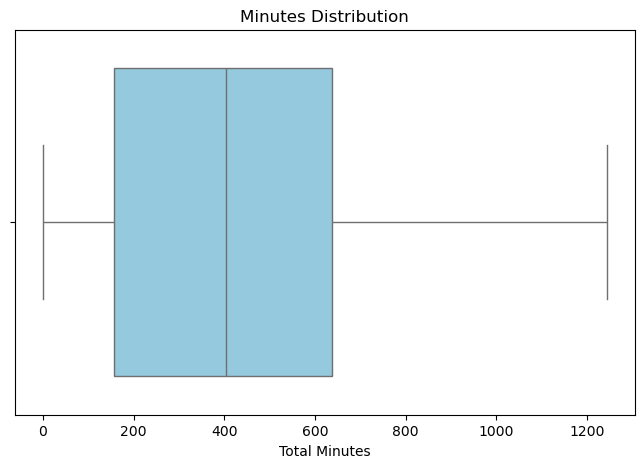

In [41]:
# Boxplot for minutes distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_player['minutes'], color='skyblue')
plt.title('Minutes Distribution')
plt.xlabel('Total Minutes')
plt.show()

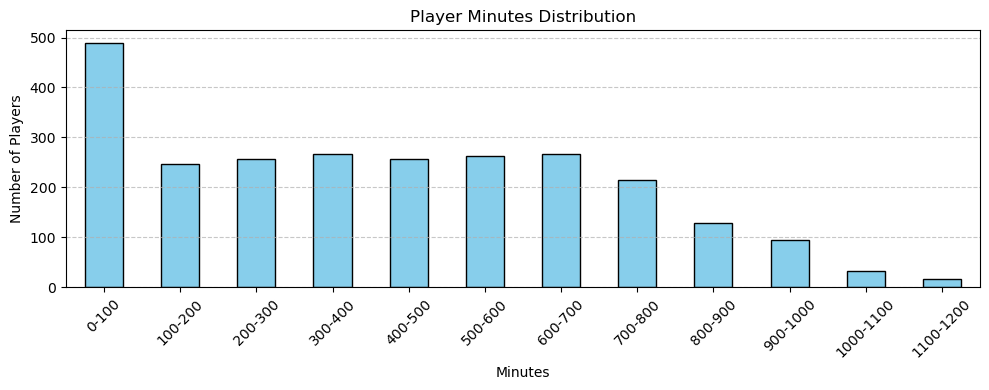

In [42]:
# Define bins for minute ranges
bins = list(range(0, 1300, 100))  
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Create a new column for the minute range
df_player['minutes_bin'] = pd.cut(df_player['minutes'], bins=bins, labels=labels, right=False)

# Count how many players fall into each range
minutes_distribution = df_player['minutes_bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 4))
minutes_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Player Minutes Distribution')
plt.xlabel('Minutes')
plt.ylabel('Number of Players')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [43]:
df_filtered = df_player[df_player['minutes'] < 5]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 25 to 2532
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   season             101 non-null    int64   
 1   player             101 non-null    object  
 2   team               101 non-null    object  
 3   games              101 non-null    int64   
 4   minutes            101 non-null    float64 
 5   points             101 non-null    int64   
 6   2s_made            101 non-null    int64   
 7   2s_attempted       101 non-null    int64   
 8   3s_made            101 non-null    int64   
 9   3s_attempted       101 non-null    int64   
 10  ft_made            101 non-null    int64   
 11  ft_attempted       101 non-null    int64   
 12  off_reb            101 non-null    int64   
 13  def_reb            101 non-null    int64   
 14  total_reb          101 non-null    int64   
 15  assists            101 non-null    int64   
 16  steals     

In [44]:
df_filtered[['season', 'team', 'player', 'minutes', 'games', 'pir']].head(150).T

,25,104,106,116,144,187,270,303,312,313,314,349,351,403,423,461,556,557,589,612,630,654,685,704,740,757,776,783,803,817,836,844,848,878,886,912,952,958,1008,1015,1022,1026,1045,1082,1102,1135,1163,1185,1225,1254,1306,1315,1324,1342,1380,1398,1412,1449,1470,1475,1509,1514,1541,1580,1600,1622,1656,1671,1732,1832,1837,1838,1852,1853,1861,1901,1903,1910,1916,1929,1934,1937,1958,1967,1991,1997,2020,2060,2122,2137,2194,2232,2300,2365,2405,2442,2490,2500,2516,2524,2532
season,2016,2016,2016,2016,2016,2016,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2022,2023,2023,2023,2023,2023,2023,2023,2023,2023,2023,2024,2024,2024,2024,2024,2024,2024,2024,2024
team,Barcelona,Darussafaka Istanbul,Darussafaka Istanbul,Fenerbahce,Maccabi Tel Aviv,Olympiacos,Barcelona,Brose Bamberg,Brose Bamberg,CSKA Moscow,CSKA Moscow,Fenerbahce,Fenerbahce,Olimpia Milano,Panathinaikos,Unicaja Malaga,CSKA Moscow,CSKA Moscow,Fenerbahce,Gran Canaria,KK Buducnost,Khimki Moscow,Olimpia Milano,Panathinaikos,Zalgiris Kaunas,ALBA Berlin,Anadolu Efes,Anadolu Efes,Barcelona,Baskonia,Bayern Munich,Bayern Munich,CSKA Moscow,Crvena Zvezda,Fenerbahce,Khimki Moscow,Olympiacos,Olympiacos,Valencia Basket,Valencia Basket,Zalgiris Kaunas,Zalgiris Kaunas,Zenit St Petersburg,Anadolu Efes,Barcelona,Bayern Munich,CSKA Moscow,Fenerbahce,Maccabi Tel Aviv,Olympiacos,Valencia Basket,Valencia Basket,Zalgiris Kaunas,Zenit St Petersburg,Anadolu Efes,Barcelona,Barcelona,CSKA Moscow,Crvena Zvezda,Crvena Zvezda,Maccabi Tel Aviv,Monaco,Olimpia Milano,Real Madrid,UNICS Kazan,Zalgiris Kaunas,ALBA Berlin,Anadolu Efes,Bayern Munich,Olympiacos,Olympiacos,Panathinaikos,Panathinaikos,Panathinaikos,Partizan,Valencia Basket,Valencia Basket,Virtus Bologna,Virtus Bologna,Zalgiris Kaunas,Zalgiris Kaunas,Zalgiris Kaunas,Anadolu Efes,Anadolu Efes,Barcelona,Barcelona,Baskonia,Fenerbahce,Olympiacos,Panathinaikos,Valencia Basket,Zalgiris Kaunas,Barcelona,Fenerbahce,Olimpia Milano,Panathinaikos,Real Madrid,Real Madrid,Virtus Bologna,Zalgiris Kaunas,Zalgiris Kaunas
player,RODIONS KURUCS,METIN TUREN,OKBEN ULUBAY,EGEHAN ARNA,DAGAN YIVZORI,VASSILIS TOLIOPOULOS,MARC GARCIA,EDDY EDIGIN,WILL MCDOWELL-WHITE,ALAN MAKIEV,ALEXANDER GANKEVICH,BARIS HERSEK,EGEHAN ARNA,SIMONE FONTECCHIO,GEORGIOS KALAITZAKIS,IGNACIO ROSA,ALEXANDER KHOMENKO,ANDREI LOPATIN,ERGI TIRPANCI,JOVAN KLJAJIC,FEDOR ZUGIC,TIMOFEY YAKUSHIN,SIMONE FONTECCHIO,GEORGIOS KALAITZAKIS,DONATAS SABECKIS,LORENZ BRENNEKE,OMERCAN ILYASOGLU,YIGITCAN SAYBIR,ARTEM PUSTOVYI,LAUTARO LOPEZ,JASON GEORGE,SASHA GRANT,ANDREI LOPATIN,NEMANJA NENADIC,BERKAY CANDAN,MAKSIM BARASHKOV,ALEKSEJ POKUSEVSKI,ETHAN HAPP,GUILLEM FERRANDO,MILLAN JIMENEZ,ERIKAS VENSKUS,KERR KRIISA,KONSTANTIN SHEVCHUK,YIGITCAN SAYBIR,BRANCOU BADIO,JASON GEORGE,YURY UMRIKHIN,BERKAY CANDAN,EIDAN ALBER,ALEXANDROS NIKOLAIDIS,GUILLEM FERRANDO,MILLAN JIMENEZ,MANTAS RUBSTAVICIUS,IGOR VOLKHIN,YIGITCAN SAYBIR,AGUSTIN UBAL,RAFA VILLAR,ANDREI LOPATIN,MARKO GUSIC,NIKOLA TOPIC,ODED BRANDWEIN,ARMEL TRAORE,RICCARDO MORASCHINI,BABA MILLER,ARTEM KOMOLOV,MOTIEJUS KRIVAS,RIKUS SCHULTE,FURKAN HALTALI,JASON GEORGE,PANAGIOTIS TSAMIS,VENIAMIN ABOSI,ALEXANDROS SAMODUROV,NEOKLIS AVDALAS,NIKOS CHOUGKAZ,DORDIJE JOVANOVIC,MILLAN JIMENEZ,SERGIO DE LARREA,GORA CAMARA,LEO MENALO,KAJUS KUBLICKAS,LIUTAURAS LELEVICIUS,MOTIEJUS KRIVAS,BURAKCAN YILDIZLI,MELIH TUNCA,DAME SARR,KASPARAS JAKUCIONIS,VIT HRABAR,HAMZA MESTOGLU,GEORGIOS TANOULIS,ALEXANDROS SAMODUROV,LUCAS MARI,NEDAS MONTVILA,RAUL VILLAR,SCOTTIE WILBEKIN,ACHILLE LONATI,DIMITRIS MORAITIS,DECLAN DURU,SIDI GUEYE,RICCARDO VISCONTI,DOVYDAS BUIKA,MANTAS JUZENAS
minutes,3.333333,0.083333,3.233333,1.15,0.066667,2.516667,1.233333,1.133333,2.316667,0.916667,1.366667,2.216667,3.1

In [45]:
# Remove players with less than 5 minutes since they barely played in whole season with mainly zero values on metrics
df_player = df_player[df_player['minutes'] >= 5].reset_index(drop=True)

In [46]:
df_player['minutes'].describe()

count    2435.000000
mean      434.423261
std       284.541559
min         5.133333
25%       189.308333
50%       425.216667
75%       651.425000
max      1243.850000
Name: minutes, dtype: float64

In [47]:
# Round minutes and convert to int
df_player['minutes'] = df_player['minutes'].round(0).astype(int)

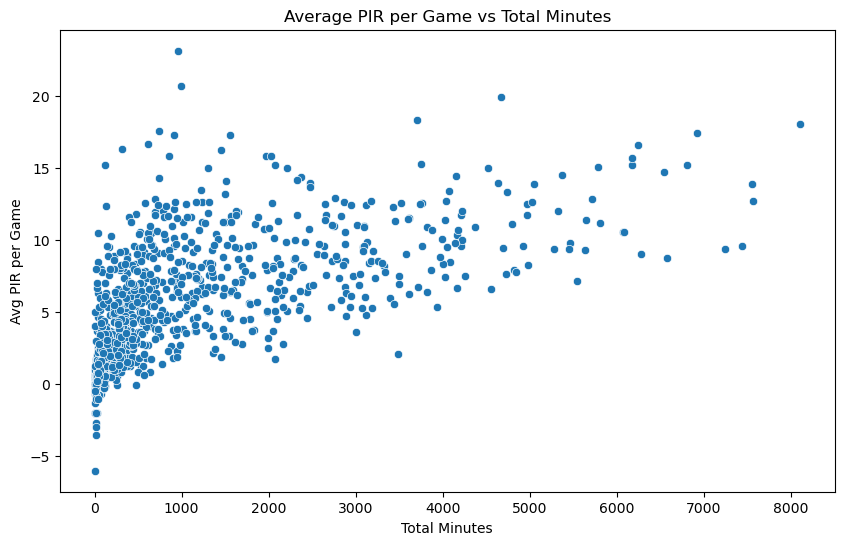

In [48]:
# View players on scatter plot 
# Calculate total minutes and average PIR per game
df_filtered = df_player.groupby('player', as_index=False).agg({
    'minutes': 'sum',
    'pir': 'sum',
    'games': 'sum'
})

# Compute average PIR
df_filtered['pir'] = df_filtered['pir'] / df_filtered['games']

# Basic scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='minutes', y='pir')
plt.title('Average PIR per Game vs Total Minutes')
plt.xlabel('Total Minutes')
plt.ylabel('Avg PIR per Game')
plt.show()

# Players bio

In [49]:
# Load the JSON data
with open('player_bio.json', 'r') as f:
    data = json.load(f)

# Process the data into a flat structure
rows = []
for season, players in data.items():
    for player in players:
        row = {
            'season': int(season[1:]),
            'player': player.get('player'),
            'height': player.get('height', 'N/A'),
            'weight': player.get('weight', 'N/A'),
            'birth_date': player.get('birth_date', 'N/A'),
            'position': player.get('position', 'N/A'),
            'country': player.get('country', 'N/A')
        }
        rows.append(row)

# Create DataFrame
df_bio  = pd.DataFrame(rows)

df_bio .head()

,season,player,height,weight,birth_date,position,country
0,2016,"ABASS, AWUDU",198.0,100.0,1993-01-27T00:00:00,Guard,Italy
1,2016,"AGRAVANIS, DIMITRIS",208.0,106.0,1994-12-20T00:00:00,Forward,Greece
2,2016,"AKOGNON, JOSH",180.0,NaN,1986-02-10T00:00:00,Guard,United States of America
3,2016,"ALDEMIR, FURKAN",207.0,108.0,1991-08-09T00:00:00,Center,Turkiye
4,2016,"ALEXANDER, JOE",203.0,NaN,1986-12-26T00:00:00,Forward,Israel


In [50]:
df_bio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2828 entries, 0 to 2827
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      2828 non-null   int64  
 1   player      2828 non-null   object 
 2   height      2821 non-null   float64
 3   weight      2766 non-null   float64
 4   birth_date  2828 non-null   object 
 5   position    2828 non-null   object 
 6   country     2828 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 154.8+ KB


In [51]:
# Convert birth_date column to date time 
df_bio['birth_date'] = pd.to_datetime(df_bio['birth_date'])

### Standardize names

In [52]:
# Use same function which was used for player stats data
df_bio['player'] = df_bio['player'].apply(standardize_name)

# Clean  white spaces
df_bio['player'] = df_bio['player'].str.strip()

df_bio.head()

,season,player,height,weight,birth_date,position,country
0,2016,AWUDU ABASS,198.0,100.0,1993-01-27,Guard,Italy
1,2016,DIMITRIS AGRAVANIS,208.0,106.0,1994-12-20,Forward,Greece
2,2016,JOSH AKOGNON,180.0,NaN,1986-02-10,Guard,United States of America
3,2016,FURKAN ALDEMIR,207.0,108.0,1991-08-09,Center,Turkiye
4,2016,JOE ALEXANDER,203.0,NaN,1986-12-26,Forward,Israel


In [53]:
# Get the most recent data from features and group df by player

# Group by player name and take the last entry
df_bio = df_bio.groupby('player', as_index=False).last()

# Drop 'season' column since we don't need it anymore
df_bio = df_bio.drop(columns='season')

df_bio.head()

,player,height,weight,birth_date,position,country
0,AARON CRAFT,188.0,88.0,1991-02-12,Guard,United States of America
1,AARON DOORNEKAMP,201.0,99.0,1985-12-05,Forward,Netherlands
2,AARON GANAL,185.0,73.0,2004-03-25,Guard,Andorra
3,AARON HARRISON,198.0,93.0,1994-10-28,Guard,United States of America
4,AARON JACKSON,190.0,83.0,1986-05-06,Guard,United States of America


In [54]:
# Check if we have bio info for all players in player stats dataset 
set(df_player['player']) - set(df_bio['player'])

{'MARCUS FRANKLEE FOSTER'}

In [55]:
df_player[df_player['player'] == 'MARCUS FRANKLEE FOSTER']

,season,player,team,games,minutes,points,2s_made,2s_attempted,3s_made,3s_attempted,ft_made,ft_attempted,off_reb,def_reb,total_reb,assists,steals,turnovers,blocks,fouls_made,fouls_drawn,pir,team_season_ended,minutes_bin
1230,2020,MARCUS FRANKLEE FOSTER,Panathinaikos,20,281,119,32,66,15,36,10,18,6,18,24,19,8,19,2,34,20,68,Panathinaikos,200-300


In [56]:
# Add missing player(checked from web)

add_player = {
    'player': 'MARCUS FRANKLEE FOSTER',
    'height': 190.0,
    'weight': 93.0,
    'birth_date': '1995-06-03',
    'position': 'Guard',
    'country': 'United States of America'
}

df_bio = pd.concat([df_bio, pd.DataFrame([add_player])], ignore_index=True)


In [57]:
# Check if we have bio info for all players in player stats dataset 
set(df_player['player']) - set(df_bio['player'])

set()

In [58]:
df_bio.tail()

,player,height,weight,birth_date,position,country
1126,ZIGA SAMAR,197.0,94.0,2001-01-26 00:00:00,Guard,Slovenia
1127,ZORAN DRAGIC,196.0,90.0,1989-06-22 00:00:00,Guard,Slovenia
1128,ZORAN NIKOLIC,212.0,107.0,1996-04-01 00:00:00,Center,Montenegro
1129,ZYLAN ANTHONY CHEATHAM,0.0,0.0,1995-11-17 00:00:00,Center,United States of America
1130,MARCUS FRANKLEE FOSTER,190.0,93.0,1995-06-03,Guard,United States of America


In [59]:
# Sort df by name 
df_bio = df_bio.sort_values(by='player').reset_index(drop=True)
df_bio

,player,height,weight,birth_date,position,country
0,AARON CRAFT,188.0,88.0,1991-02-12 00:00:00,Guard,United States of America
1,AARON DOORNEKAMP,201.0,99.0,1985-12-05 00:00:00,Forward,Netherlands
2,AARON GANAL,185.0,73.0,2004-03-25 00:00:00,Guard,Andorra
3,AARON HARRISON,198.0,93.0,1994-10-28 00:00:00,Guard,United States of America
4,AARON JACKSON,190.0,83.0,1986-05-06 00:00:00,Guard,United States of America
...,...,...,...,...,...,...
1126,ZAYD MUOSA,198.0,88.0,2003-07-03 00:00:00,Guard,Cyprus
1127,ZIGA SAMAR,197.0,94.0,2001-01-26 00:00:00,Guard,Slovenia
1128,ZORAN DRAGIC,196.0,90.0,1989-06-22 00:00:00,Guard,Slovenia
1129,ZORAN NIKOLIC,212.0,107.0,1996-04-01 00:00:00,Center,Montenegro


In [60]:
# We only need the players data for the players in df_player
# Remove extra names in df_bio
df_bio = df_bio[df_bio['player'].isin(df_player['player'])]

df_bio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926 entries, 0 to 1130
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   player      926 non-null    object 
 1   height      924 non-null    float64
 2   weight      886 non-null    float64
 3   birth_date  926 non-null    object 
 4   position    926 non-null    object 
 5   country     926 non-null    object 
dtypes: float64(2), object(4)
memory usage: 50.6+ KB


In [61]:
# Check count of NaN values
df_bio.isna().sum()

player         0
height         2
weight        40
birth_date     0
position       0
country        0
dtype: int64

In [62]:
# Check entries with NaN values
df_filtered = df_bio[df_bio[['height', 'weight']].isnull().any(axis=1)]
df_filtered.head(100).T

,35,47,62,75,84,97,108,144,147,156,170,173,189,232,266,270,284,288,424,430,482,486,497,500,502,520,531,544,592,598,672,833,835,842,910,924,1034,1073,1080,1115
player,ALEKSANDR KARPUKHIN,ALEX KIRK,ALI MUHAMMED,ANDREA BARGNANI,ANDRES NOCIONI,ANTHONY BENNETT,ANTONIS FOTSIS,BLAKE SCHILB,BOGDAN BOGDANOVIC,BRAD OLESON,BRUNO FITIPALDO,BRYCE COTTON,CHASE BUDINGER,DARIUS MILLER,DEVIN SMITH,DIAMON SIMPSON,DOMINIC WATERS,DONTAYE DRAPER,IOANNIS BOUROUSIS,ISAIAH HARTENSTEIN,JEFF AYRES,JEREL McNEAL,JOE ALEXANDER,JOEL FREELAND,JOEY DORSEY,JONATHAN HOLMES,JOSH AKOGNON,JUSTIN DENTMON,KOSTAS KAIMAKOGLOU,KYLE BRANDON O'QUINN,MARCUS SLAUGHTER,ORHAN HACIYEVA,ORLANDO JOHNSON,PABLO PRIGIONI,ROBERTAS JAVTOKAS,RUSS SMITH,TREVOR COONEY,VITOR FAVERANI,VLADIMIR VEREMEENKO,YORDAN MINCHEV
height,191.0,211.0,NaN,213.0,203.0,203.0,209.0,201.0,197.0,191.0,184.0,185.0,201.0,203.0,198.0,203.0,185.0,181.0,215.0,210.0,206.0,191.0,203.0,210.0,203.0,204.0,180.0,183.0,NaN,206.0,204.0,203.0,196.0,186.0,211.0,183.0,193.0,210.0,211.0,202.0
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birth_date,1990-05-06 00:00:00,1991-11-14 00:00:00,1983-04-10 00:00:00,1985-10-26 00:00:00,1979-11-30 00:00:00,1993-03-14 00:00:00,1981-04-02 00:00:00,1983-12-23 00:00:00,1992-08-18 00:00:00,1983-04-11 00:00:00,1991-08-02 00:00:00,1992-08-11 00:00:00,1988-05-22 00:00:00,1990-03-21 00:00:00,1983-04-12 00:00:00,1987-09-08 00:00:00,1986-09-28 00:00:00,1984-08-10 00:00:00,1983-11-17 00:00:00,1998-05-05 00:00:00,1987-04-29 00:00:00,1987-06-01 00:00:00,1986-12-26 00:00:00,1987-02-07 00:00:00,1983-12-16 00:00:00,1992-12-09 00:00:00,1986-02-10 00:00:00,1985-09-05 00:00:00,1983-03-15 00:00:00,1990-03-26 00:00:00,1985-03-18 00:00:00,1989-10-01 00:00:00,1989-03-11 00:00:00,1977-05-17 00:00:00,1980-03-20 00:00:00,1991-04-19 00:00:00,1992-08-01 00:00:00,1988-05-05 00:00:00,1984-07-21 00:00:00,1998-10-17 00:00:00
position,Guard,Center,Guard,Center,Forward,Forward,Forward,Forward,Guard,Guard,Guard,Guard,Forward,Forward,Forward,Forward,Guard,Guard,Center,Forward,Center,Guard,Forward,Center,Center,Forward,Guard,Guard,Forward,Center,Forward,Forward,Guard,Guard,Center,Guard,Guard,Center,Center,Forward
country,Russian Federation,United States of America,United States of America,Italy,Italy,Canada,Greece,United States of America,Serbia,Spain,Italy,United States of America,United States of America,United States of America,United States of America,United States of America,United States of America,United States of America,Greece,Germany,United States of America,United States of America,Israel,United Kingdom,United States of America,United States of America,United States of America,United States of America,Greece,United States of America,United States of America,Turkiye,United States of America,Spain,Lithuania,United States of America,United States of America,Spain,Russian Federation,Bulgaria


## Create a long table to use for radar chart on tableau

#### Features: 

* 3s
* 2s
* Free Throws
* Off. Rebounds
* Def. Rebounds
* Assists
* Steals
* Blocks

In [63]:
# Create an empty df for long table
df_radar = pd.DataFrame(columns=['player', 'season', 'radar_metric', 'radar_value'])

In [64]:
# Create a base df to use for calculations 
df_base = (
    df_player.groupby(['player', 'season'], as_index=False)
    .agg({
        'games': 'sum',
        'minutes': 'sum',
        'points': 'sum',
        '2s_made': 'sum',
        '2s_attempted': 'sum',
        '3s_made': 'sum',
        '3s_attempted': 'sum',
        'ft_made': 'sum',
        'ft_attempted': 'sum',
        'off_reb': 'sum',
        'def_reb': 'sum',
        'total_reb': 'sum',
        'assists': 'sum',
        'steals': 'sum',
        'turnovers': 'sum',
        'blocks': 'sum',
        'fouls_made': 'sum',
        'fouls_drawn': 'sum',
        'pir': 'sum'
    })
)

In [65]:
# Calculate each player's percentile rank for 3-pointers made per game within their season
df_base['3s_pg'] = df_base['3s_made'] / df_base['games'].replace(0, np.nan) 
# Calculate ranking percentage 
df_base['3s_rank'] = df_base.groupby('season')['3s_pg'].rank(pct=True)

In [66]:
# Calculate percentile rank with per game values for all other features
df_base['2s_pg'] = df_base['2s_made'] / df_base['games'].replace(0, np.nan) 
df_base['2s_rank'] = df_base.groupby('season')['2s_pg'].rank(pct=True)

df_base['steals_pg'] = df_base['steals'] / df_base['games'].replace(0, np.nan) 
df_base['steals_rank'] = df_base.groupby('season')['steals_pg'].rank(pct=True)

df_base['ft_pg'] = df_base['ft_made'] / df_base['games'].replace(0, np.nan) 
df_base['ft_rank'] = df_base.groupby('season')['ft_pg'].rank(pct=True)

df_base['off_reb_pg'] = df_base['off_reb'] / df_base['games'].replace(0, np.nan) 
df_base['off_reb_rank'] = df_base.groupby('season')['off_reb_pg'].rank(pct=True)

df_base['def_reb_pg'] = df_base['def_reb'] / df_base['games'].replace(0, np.nan) 
df_base['def_reb_rank'] = df_base.groupby('season')['def_reb_pg'].rank(pct=True)

df_base['assists_pg'] = df_base['assists'] / df_base['games'].replace(0, np.nan) 
df_base['as_rank'] = df_base.groupby('season')['assists_pg'].rank(pct=True)

df_base['blocks_pg'] = df_base['blocks'] / df_base['games'].replace(0, np.nan) 
df_base['blocks_rank'] = df_base.groupby('season')['blocks_pg'].rank(pct=True)

In [67]:
# Drop unnecessary columns
cols_to_drop = ['3s_pg', '2s_pg', 'ft_pg', 'off_reb_pg', 'def_reb_pg', 'assists_pg', 'blocks_pg', 'steals_pg']
df_base = df_base.drop(columns=cols_to_drop)

In [68]:
# Create the radar chart format and features
# List of fields to melt
rank_fields = ['ft_rank', '2s_rank', '3s_rank', 'def_reb_rank', 'off_reb_rank', 'as_rank',  'steals_rank', 'blocks_rank']

# Melt into long format
df_radar = df_base.melt(
    id_vars=['player', 'season'],
    value_vars=rank_fields,
    var_name='radar_metric',
    value_name='radar_value'
)

df_radar.head(10)

,player,season,radar_metric,radar_value
0,AARON CRAFT,2018,ft_rank,0.033195
1,AARON DOORNEKAMP,2017,ft_rank,0.608163
2,AARON DOORNEKAMP,2019,ft_rank,0.207143
3,AARON HARRISON,2020,ft_rank,0.789199
4,AARON JACKSON,2016,ft_rank,0.567797
5,AARON JACKSON,2019,ft_rank,0.364286
6,AARON WHITE,2017,ft_rank,0.767347
7,AARON WHITE,2018,ft_rank,0.896266
8,AARON WHITE,2019,ft_rank,0.364286
9,AARON WHITE,2020,ft_rank,0.742160


In [69]:
# Sort df by season first
df_radar = df_radar.sort_values(by=['season']).reset_index(drop=True)

In [70]:
# Now sort by player and season to ensure consistent order for radar chart
df_radar = df_radar.sort_values(by=['player','season', 'radar_metric']).reset_index(drop=True)

In [71]:
# Set a fixed order for the metrics for radar chart
metric_order = [
    'ft_rank', '2s_rank', '3s_rank', 'def_reb_rank', 'off_reb_rank', 'as_rank', 
    'steals_rank', 'blocks_rank'
]

# Apply the ordered categories to radar_metric column
df_radar['radar_metric'] = pd.Categorical(df_radar['radar_metric'], categories=metric_order, ordered=True)

# Sort the dataframe again to ensure it follows this new order
df_radar = df_radar.sort_values(by=['player', 'season', 'radar_metric']).reset_index(drop=True)

In [72]:
df_radar.head(20)

,player,season,radar_metric,radar_value
0,AARON CRAFT,2018,ft_rank,0.033195
1,AARON CRAFT,2018,2s_rank,0.211618
2,AARON CRAFT,2018,3s_rank,0.103734
3,AARON CRAFT,2018,def_reb_rank,0.176349
4,AARON CRAFT,2018,off_reb_rank,0.738589
5,AARON CRAFT,2018,as_rank,0.796680
6,AARON CRAFT,2018,steals_rank,0.518672
7,AARON CRAFT,2018,blocks_rank,0.120332
8,AARON DOORNEKAMP,2017,ft_rank,0.608163
9,AARON DOORNEKAMP,2017,2s_rank,0.265306


In [73]:
df_radar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19296 entries, 0 to 19295
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   player        19296 non-null  object  
 1   season        19296 non-null  int64   
 2   radar_metric  19296 non-null  category
 3   radar_value   19296 non-null  float64 
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 471.6+ KB


In [74]:
# Add 1 to season values since ending year represents the played season
df_player['season'] = df_player['season'] + 1
df_team['season'] = df_team['season'] + 1
df_radar['season'] = df_radar['season'] + 1

## Save DataFrames 

In [75]:
df_player.to_csv('players_2016_2025.csv', index=False)
df_team.to_csv('teams_2016_2025.csv', index=False)
df_radar.to_csv('rankings_2016_2025.csv', index=False)
df_bio.to_csv('players_bio_2016_2025.csv', index=False)